# Exercise 4 - R: Neural Networks Learning

<img src="http://neuralnetworksanddeeplearning.com/images/tikz11.png">

## Part I: *Neural Networks*

Recognizing handwritten digits.  Though the source is not explicitly mentioned, it is just like the [MNIST database](https://en.wikipedia.org/wiki/MNIST_database).

Each value of $X$ will be a 20x20 grid of values representing the grayscale intensity at that location "unrolled" into a 400-dimensional vector.  Here is an example for the first number in our data, $X^{(1)}$:

$\hspace{1cm} X^{(1)} = \begin{bmatrix}x_{(1, 1)}^{(1)},\ x_{(1, 2)}^{(1)},\ \dots\ x_{(1, 20)}^{(1)} \\
                                    x_{(2, 1)}^{(1)},\ x_{(2, 2)}^{(1)},\ \dots\ x_{(2, 20)}^{(1)} \\
                                    \vdots \\ 
                                    x_{(20, 1)}^{(1)},\ x_{(20, 2)}^{(1)},\ \dots\ x_{(20, 20)}^{(1)} \\ 
                    \end{bmatrix}
\rightarrow \begin{bmatrix} x_1^{(1)},\ x_2^{(1)},\ \dots\ x_{400}^{(1)} \end{bmatrix}
\rightarrow (x^{(1)})^T$

Here is our collection of all of the numbers for $X$:

$\hspace{1cm} X = \begin{bmatrix} (x^{(1)})^T \\ (x^{(2)})^T \\ \vdots \\ (x^{(400)})^T \end{bmatrix}$

---

Beginning with package imports, data loading, and initial visualization

In [1]:
rm(list=ls())  # Clearing all environment variables

suppressPackageStartupMessages({
  library(R.matlab)  # Reads MATLAB/Octave  matrices
  library(utils)  # Used for a status bar in lengthy for loops
  library(nnet)  # For comparing answers
  library(ggplot2)
  library(tidyr)
  library(dplyr)
})

theme_update(plot.title = element_text(hjust = 0.5))  # Centers ggplot2 titles

Warning message:
"package 'R.matlab' was built under R version 3.3.3"Warning message:
"package 'tidyr' was built under R version 3.3.3"

In [2]:
# Loading in the data from the .mat files
data <- readMat('ex4/ex4data1.mat')

# Assigning X/y and removing data from environment
X <- data$X
y <- data$y


# Loading in the weights from the .mat files
data <- readMat('ex4/ex4weights.mat')

# Assigning theta1/2 and removing data from environment
theta1 <- data$Theta1
theta2 <- data$Theta2
rm(data)  # Clearing data from environment

print(dim(X))

[1] 5000  400


Note: y has 0 listed as 10, but we will be leaving this alone until our final predictions since the thetas we are provided for the first part of the exercise are structured for this.  In other words, it would be more trouble than it's worth to reshape our provided thetas.

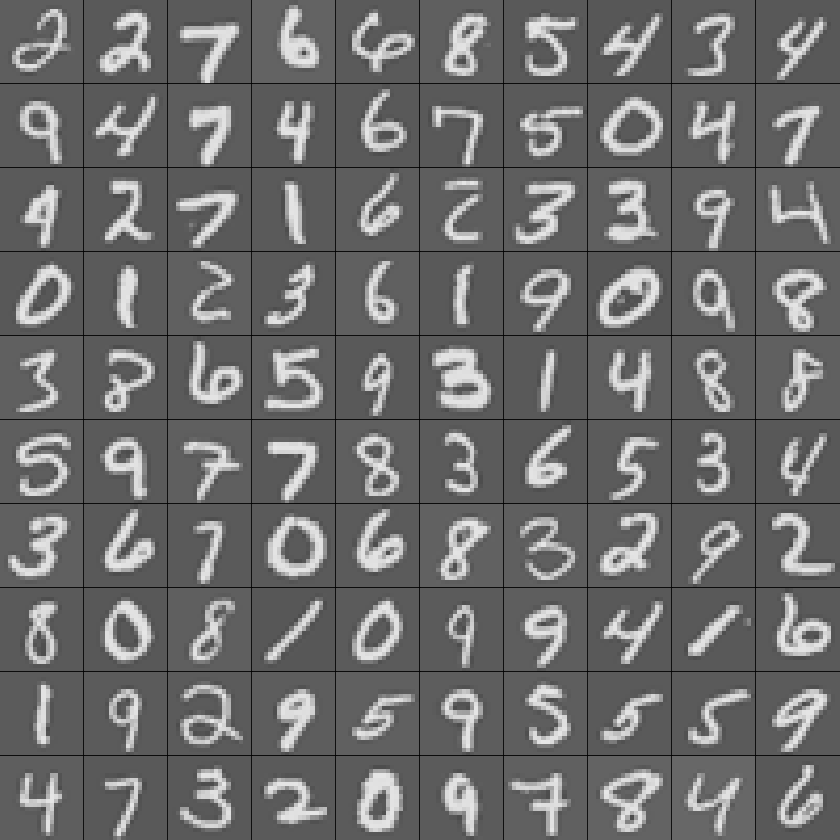

In [3]:
# Randomly selecting 100 digits to plot
rowsToPlot <- X[sample(nrow(X),size=100,replace=FALSE),]

row_to_matrix <- function(row) {
  # Formats a row from the matrix X into a matrix suitable for plotting with image()
  digit <- matrix(row, nrow=20, ncol=20)  # Puts row into a 20x20 matrix
  digit <- t(apply(digit, 2, rev))  # Rotates matrix into correct position for image()
  return(digit)
}

plot_digits <- function(digits) {
  # Plots a grid of the supplied digits
  
  # Calculating parameters for the plot
  m <- dim(digits)[1]  # Number of digits to plot
  columns <- floor(sqrt(m))  # Number of columns
  rows <- ceiling(sqrt(m))  # Number of rows

  # Parameters for the overall plot
  par(mfrow=c(rows, columns),  # Rows, columns
      mar=c(0.0, 0.0, 0.0, 0.0))  # Margins between plots

  # Looping through the digits and plotting them
  for (i in 1:m) {
  image(row_to_matrix(digits[i, ]),  # Formats digit
        col=grey.colors(255),  # Colors to gray scale
        xaxt='n', yaxt='n')  # Remoxes axis labels and tick marks
  }
}

plot_digits(rowsToPlot)

### Feedforward and Cost Function

$J(\theta) = \frac{1}{m} \sum_{i=1}^m \sum_{k=1}^K \big[-y_k^{(i)}log((h_\theta(x^{(i)}))_k) - (1-y_k^{(i)}) log(1-(h_\theta(x^{(i)}))_k) \big] + \frac{\lambda}{2m} \big[\sum_{j=1}^{25} \sum_{k=1}^{400} (\theta_{j, k}^{(1)})^2 +
\sum_{j=1}^{10} \sum_{k=1}^{25} (\theta_{j, k}^{(2)})^2 \big]$

Note: $h_\theta(x^{(i)})_k = a^{(3)}_k$, or the activation of the $k$-th output unit

#### Regularization Parameter

$\frac{\lambda}{2m} \big[\sum_{j=1}^{25} \sum_{k=1}^{400} (\theta_{j, k}^{(1)})^2 +
\sum_{j=1}^{10} \sum_{k=1}^{25} (\theta_{j, k}^{(2)})^2 \big]$

Note: The regularization parameter ignores the bias units

The exercise states that the unregularized cost function should be around $0.287629$, and the regularized cost function with $\lambda = 1$ should be around $0.383770$

In [4]:
sigmoid <- function(z) {
  # Calculates the sigmoid function for use as the activation function in the neural network
  z <- 1/(1+exp(-z))
  return(z)
}


forward_propagate <- function(thetas, X) {
    # Forward propagates a sequential neural network with the provided input
    # Assumes X does not contain the bias term
  
    # Returns the following:
    # Prediction: Numerical predictions
    # ClassProbability: Class probabilities
    # Nodes: Values of the nodes pre-activation (excluding input layer)
    # Activations: Values of the nodes post-activation (exluding input layer)
  
  h <- as.matrix(X)
  
  # To store neuron values for backpropagation
  nodes <- list()
  activations <- list()
  activations[[1]] <- cbind(1, h)
  
  # Forward propagation
  iteration <- 1  # For getting similar function to Python's enumerate()
  for (theta in thetas) {
    h <- cbind(1, h)  # Adding the bias term
    h <- as.matrix(h) %*% t(as.matrix(theta))  # Multiplying by the weights
    nodes[[iteration]] <- h
    h <- sigmoid(h)  # Activation function
    activations[[iteration+1]] <- cbind(1, h)
    iteration <- iteration + 1
  }

  prediction <- data.frame(h)
  colnames(prediction) <- c(1:9, 0)
  prediction <- colnames(prediction)[max.col(prediction,ties.method="first")]
  
  return(list("Prediction" = prediction, "ClassProbability" = h,
              "Nodes" = nodes, "Activations" = activations))
}


nn_cost <- function(thetas, X, y, C=0.0) {
  # Returns the cost for a sequential neural network using the forward_propagate function
  m <- length(y)
  
  # Generating class probabilities
  h <- forward_propagate(thetas, X)$ClassProbability
  
  # One hot encoding y
  yOneHot <- y %>% 
    data.frame(digit=.) %>%  # Creating a data frame
    mutate(id = 1:n(), dummy = 1) %>%  # Adding columns before the encoding
    spread(digit, value = dummy, fill = 0) %>%  # One hot encoding
    select(-id)  # Removing ID
  
  # Calculating the regularized cost
  error <- sum(-yOneHot * log(h) - (1 - yOneHot) * log(1 - h))
  
  # Removing the bias term from regularization
  regParameter <- lapply(thetas, function(x) x[, -1]^2) %>% 
                    unlist() %>% 
                    sum()
  regParameter <- (C/(2*m)) * regParameter
  
  cost <- (1/m) * error + regParameter
  
  return(cost)
}


cat('Unregularized cost:', nn_cost(list(theta1, theta2), X, y), '\n')
cat('Regularized cost:', nn_cost(list(theta1, theta2), X, y, 1.0))

Unregularized cost: 0.2876292 
Regularized cost: 0.3837699

---

##  Part II: *Backpropagation*

Here we'll learn parameters for our neural network through backpropagation.  We have to first create two helper functions in order to conduct backpropagation:

1. **restructure_theta:** The optimization function won't work with matrices, so we have to flatten our thetas into one long vector.  This function will allow us to reshape the vector back into the original matrices for theta in order to use it with the **forward_propagate** function.
2. **sigmoid_gradient:** The partial derivative of the sigmoid function which will be used to help calculate the gradient in backpropagation

After that, we will have to create new values for our initial $\Theta^{(l)}$.  We can't use $0$s like we did in the previous exercises because this more or less causes our nodes to drop out.

We'll then finally build the backpropogation function, and then proceed with optimizing our $\Theta^{(l)}$ and generate predictions.

In [5]:
# Creating a long theta to plug into functions
longTheta <- c(as.vector(t(theta1)), as.vector(t(theta2)))


restructure_thetas <- function(long_theta, thetas) {
  # Reshapes a long array of thetas into matrices for each theta
  counter <- 1
  indices <- 0
  reshapedThetas <- list()
  for (theta in thetas) {
    if (counter == 1) {
      reshapedTheta <- matrix(long_theta[1:length(theta)], nrow=dim(theta)[1],
                              ncol=dim(theta)[2], byrow=TRUE)
      reshapedThetas[[counter]] <- reshapedTheta
      indices <- indices + length(theta)
      counter <- counter + 1
    }
    else {
      reshapedTheta <- matrix(long_theta[(1+indices):(indices+length(theta))],
                              nrow=dim(theta)[1], ncol=dim(theta)[2], byrow=TRUE)
      reshapedThetas[[counter]] <- reshapedTheta
      indices <- indices + length(theta)
      counter <- counter + 1
    }
  }
  return(reshapedThetas)
}


cat('Original theta 2 shape:',
    dim(theta2), '\n')
cat('Reshaped theta 2 shape:',
    dim(restructure_thetas(longTheta, list(theta1, theta2))[[2]]))

Original theta 2 shape: 10 26 
Reshaped theta 2 shape: 10 26

### Sigmoid Gradient

$g'(z) = \frac{d}{dz}g(z) = g(z)(1-g(z))$

where

$sigmoid(z)=g(z)=\frac{1}{1+e^{-z}}$

In [6]:
sigmoid_gradient <- function(z) {
  # Returns the gradient of a sigmoid function
  gradient <- sigmoid(z) * (1-sigmoid(z))
  return(gradient)
}

sigmoid_gradient(0)

[1] 0.25

### Random Initialization

Randomly selecting values for $\Theta^{(l)}$ uniformly in the range $[-\epsilon_{init}, \epsilon_{init}]$ since initial $\Theta^{(l)}$ values of $0$ will more or less cancel out the neurons they are assigned to

We will use the recommended approach for selecting $\epsilon$ by using the number of units in the network:

$\epsilon_{init} =  \frac{\sqrt(6)}{\sqrt{L_{in}+L_{out}}}$

where

$L_{in} = s_l$ and $L_{out} = s_{l+1}$, or the number of nodes in the input and output layers (excluding the bias nodes)

In [7]:
# Num nodes in the input and output layers (excl. bias nodes)
epsilon <- sqrt(6) / sqrt(400+10)

initialThetas <- runif(length(longTheta), min=-epsilon, max=epsilon)

length(initialThetas)

[1] 10285

### Backpropagation

<img src="https://sebastianraschka.com/images/faq/visual-backpropagation/backpropagation.png">

As a reminder, backpropagation is a way to learn parameters for neural networks.  On a high level, we first propagate forward with initial parameters (which we created above by uniformly selecting between $[-\epsilon_{init}, \epsilon_{init}]$), then we obtain the error for our output nodes, and use that to do weighted averages moving backwards through the network to find which nodes in the hidden layer contributed to the error.  We can then calculate the gradient which tells us how we can adjust the parameters to decrease the error.  Finally, we pair it with an optimization algorithm in order to perform several iterations.

Vectorized implementations of backpropagation exist, but Professor Ng stressed using a for loop that iterates through each training example for the sake of simplicity.  Here is the mechanical approach for performing gradient descent:

$\hspace{0.5cm}$ **Note:** These formulas are specific to our neural network with one hidden layer

1. Set the input layer's values $(a^{(1)})$ to the $t$-th training example $x^{(t)}$.  Perform a feedforward pass to compute the activations $(z^{(2)}, a^{(2)}, z^{(3)}, a^{(3)})$ for layers 2 and 3.  Remember to add the $+1$ term to ensure the vectors of activation for layers $a^{(1)}$ and $a^{(2)}$ also include the bias unit.

2. For each output unit $k$ in layer 3 (the output layer), set $$\delta_k^{(3)} = (a_k^{(3)} - y_k)$$ where $y_k \in \{0,1\}$ indicates whether the current training example belongs to class $k (y_k = 1)$, or if it belongs to a different class $(y_k = 0)$.  This is an "error term" that measures how much that node was "responsible" for any errors in the output.

3. For the hidden layer $l=2$, set $$\delta^{(2)} = (\theta^{(2)})^T \delta^{(3)}.*g'(z^{(2)})$$ This is the part that propagates backward, and like step 2, it is an "error" term that measures how much that node was "responsible" for any errors in the output.  However, we determine this by a weighted average of the error terms in the output layer $(l+1)$.

4. Accumulate the gradient from this training example using the following formula.  Note that you should skip or remove $\delta_0^{(2)}$ $$ \Delta^{(l)} = \Delta^{(l)} + \delta^{(l+1)} (a^{(l)})^T$$

5. Obtain the (unregularized) gradient for the neural network cost function by multiplying the accumulated gradients by $\frac{1}{m}$: $$\frac{\partial}{\partial \theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)} = \frac{1}{m}\Delta_{ij}^{(l)}$$

5. Obtain the regularized gradient for the neural network cost function by multiplying the accumulated gradients by $\frac{1}{m}$ and applying the regularization term: $$\frac{\partial}{\partial \theta_{ij}^{(l)}}J(\Theta) = D_{ij}^{(l)} = \begin{cases}\frac{1}{m}\Delta_{ij}^{(l)} & for\ j=0 \\ \frac{1}{m}\Delta_{ij}^{(l)} + \frac{\lambda}{m}\Theta_{ij}^{(l)} & for\ j\geq 1 \end{cases}$$

Using the obtained gradient, we can adjust the values of $\Theta^{(l)}$ and do it all over again.

In [8]:
backpropagate <- function(long_theta, thetas, X, y, C=0.0) {
  # Calculates the gradients for provided thetas through 
  # long_thetas is the vector of all thetas, and is the first parameter
  # since this is what the optimization changes

  # Also calculates the cost using nn_cost()
  m <- length(y)
  
  # Reshaping long_theta into original form for forward_propagate()
  reshaped_thetas <- restructure_thetas(long_theta, thetas)
  
  # Gathering info from forward propagation
  forwardProp <- forward_propagate(reshaped_thetas, X)
  h <- forwardProp$ClassProbability
  nodes <- forwardProp$Nodes
  activations <- forwardProp$Activations
  
  cost <- nn_cost(reshaped_thetas, X, y, C)
  
  # One hot encoding y
  yOneHot <- y %>% 
    data.frame(digit=.) %>%  # Creating a data frame
    mutate(id = 1:n(), dummy = 1) %>%  # Adding columns before the encoding
    spread(digit, value = dummy, fill = 0) %>%  # One hot encoding
    select(-id)  # Removing ID
  
  # Creating initial deltas of 0 to be filled
  delta1 <- numeric(length(reshaped_thetas[[1]]))
  delta2 <- numeric(length(reshaped_thetas[[2]]))
  
  # Looping through each individual digit in the training set
  for (digit in 1:m) {
    # Step 1: Grabbing appropriate items for the backpropagation calculation
    # Using t(matrix()) to quickly reshape for linear algebra
    input_nodes <- t(matrix(activations[[1]][digit, ]))  # (1, 401)
    hidden_nodes <- t(matrix(nodes[[1]][digit, ]))  # (1, 25)
    hidden_activation <- t(matrix(activations[[2]][digit, ]))  # (1, 26)
    output_nodes <- h[digit, ]  # (NULL)
    actual <- yOneHot[digit, ]  # (1, 10)
    
    # Step 2: Calculating delta 3 - the "error term" assigning responsibilitiy
    # of errors to nodes in the output layer
    d3 <- matrix(output_nodes - actual)  # (10, 1)
    hidden_nodes <- cbind(1, hidden_nodes)  # Adding the bias term  # (1, 26)
    
    # Step 3: Calculating delta 2 - the weighted average of error terms in
    # the output layer to assign responsibility to nodes in the hidden layer
    d2 <- as.numeric((t(as.numeric(d3)) %*% reshaped_thetas[[2]]) %*%
                       t(sigmoid_gradient(hidden_nodes))) * sigmoid_gradient(hidden_nodes)
    
    # Step 4: Accumulating the gradients
    delta1 <- delta1 + as.matrix(d2[, -1]) %*% input_nodes
    delta2 <- delta2 + as.numeric(d3) %*% hidden_activation
  }
  
  # Step 5: Obtaining the gradient for the cost function
  delta1 <- (1/m) * delta1
  delta2 <- (1/m) * delta2
  
  # Adding the regularization terms
  delta1[, -1] <- delta1[, -1] + (reshaped_thetas[[1]][, -1] * C) / m
  delta2[, -1] <- delta2[, -1] + (reshaped_thetas[[2]][, -1] * C) / m

  # Combining the gradients into one long gradient for the optimization function
  gradient <- c(as.vector(t(delta1)), as.vector(t(delta2)))
  
  return(list("Cost" = cost, "Gradient" = gradient))
}

backprop <- backpropagate(initialThetas, list(theta1, theta2), X, y, 1.0)
backprop$Cost
backprop$Gradient[1:5]

[1] 7.183496

[1]  2.234785e-02  2.093315e-05  7.871836e-06  8.415302e-06 -1.904832e-05

### Optimizing $\Theta^{(l)}$ and Predictions

In [9]:
# Creating helper functions for the optimization function
backpropagate.cost <- function(long_theta, thetas, X, y, C=0.0) {
  backpropagate(long_theta, thetas, X, y, C=0.0)$Cost
}

backpropagate.gradient <- function(long_theta, thetas, X, y, C=0.0) {
  backpropagate(long_theta, thetas, X, y, C=0.0)$Gradient
}

startTime <- proc.time()

optimalTheta <- optim(
        # Specifying function parameters
        par=initialThetas,  # Initial guess
        fn=backpropagate.cost,  # Function to minimize
        gr=backpropagate.gradient,
        X=X,
        y=y,
        thetas=list(theta1, theta2),
        C=1.0,
        method="BFGS",  #  Optimization function to use
        control=list(maxit = 250)  # Maximum number of iterations
      )$par  # Specifying that we only want the obtained thetas

optimalTheta[1:5]

endTime <- proc.time()  
endTime - startTime

[1] -3.00345272  0.10466573  0.03935918  0.04207312 -0.09513134

   user  system elapsed 
6523.92    9.86 6798.64 

In [10]:
initialThetaList <- restructure_thetas(initialThetas, list(theta1, theta2))
newThetaList <- restructure_thetas(optimalTheta, list(theta1, theta2))

cat('Initial cost:', nn_cost(initialThetaList, X, y), '\n')
cat('Optimized theta cost:', nn_cost(newThetaList, X, y))

Initial cost: 7.178395 
Optimized theta cost: 0.9219772

In [11]:
predictions <- forward_propagate(newThetaList, X)$Prediction

results <- data.frame(Prediction = as.numeric(predictions)) %>% 
  mutate(Actual = y)

results$Correct <- ifelse(results$Prediction == results$Actual, 1, 0)

cat('Our accuracy:', mean(results$Correct))

Our accuracy: 0.7304

---

##  Part III: *Visualizing the hidden layer*

Here we will visualize the representations captured by the hidden layer.  This is done by reshaping the hidden layer $\Theta$ into a 20x20 matrix and plotting it.  This will give us an idea of the patterns our network is learning.  It's a similar idea of [eigenfaces](https://en.wikipedia.org/wiki/Eigenface) (even though the math behind them is different), and it is really cool!

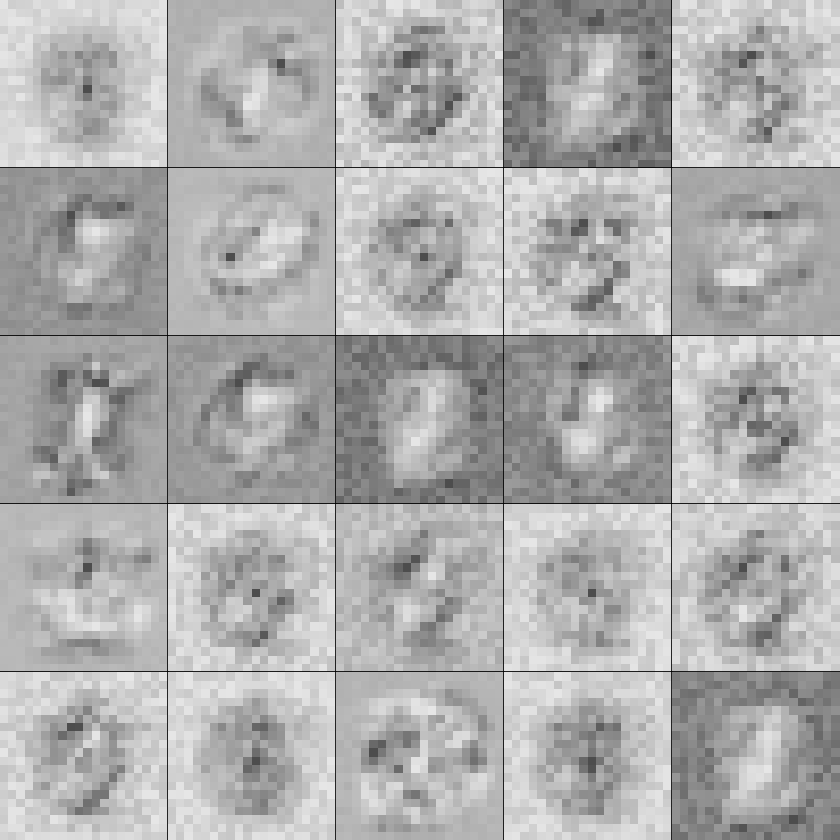

In [12]:
hiddenTheta <- restructure_thetas(optimalTheta, list(theta1, theta2))[[1]][,-1]

plot_hidden_layer <- function(theta) {
  # Visualizes the hidden layer by plotting the values of theta applied
  # to the input layer.  Darker sections correspond to heavier weights.
  
  # Calculating parameters for the plot
  m <- dim(theta)[1]  # Number of digits to plot
  columns <- floor(sqrt(m))  # Number of columns
  rows <- ceiling(sqrt(m))  # Number of rows

  # Parameters for the overall plot
  par(mfrow=c(rows, columns),  # Rows, columns
      mar=c(0.0, 0.0, 0.0, 0.0))  # Margins between plots

  # Looping through the digits and plotting them
  for (i in 1:m) {
  image(row_to_matrix(theta[i, ]),  # Formats theta
        xaxt='n', yaxt='n')  # Remoxes axis labels and tick marks
  }
}

plot_digits(hiddenTheta)